
[Aşama 1/3] Kaydedilmiş modeller bulunamadı. Optimizasyon ve eğitim başlıyor...
'hog_color_lbp_glcm_augmented_4class.pkl' dosyasındaki öznitelikler yükleniyor...

PCA sonrası yeni öznitelik boyutu: 2301
Hiper-parametre optimizasyonu için 7366 adet alt örneklem kullanılacak.

>>> SVM için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
En iyi SVM parametreleri: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
En iyi SVM skoru (alt örneklemde): 0.8532

>>> MLP için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
En iyi MLP parametreleri: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
En iyi MLP skoru (alt örneklemde): 0.7892

>>> XGBoost için hızlı optimizasyon başlıyor...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
En iyi XGBoost parametreleri: {'learning_rate': 0.1, 'n_estimators': 200}
En iyi XGBoost skoru (alt örneklemde): 0.8084

--- Model (SVM) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---



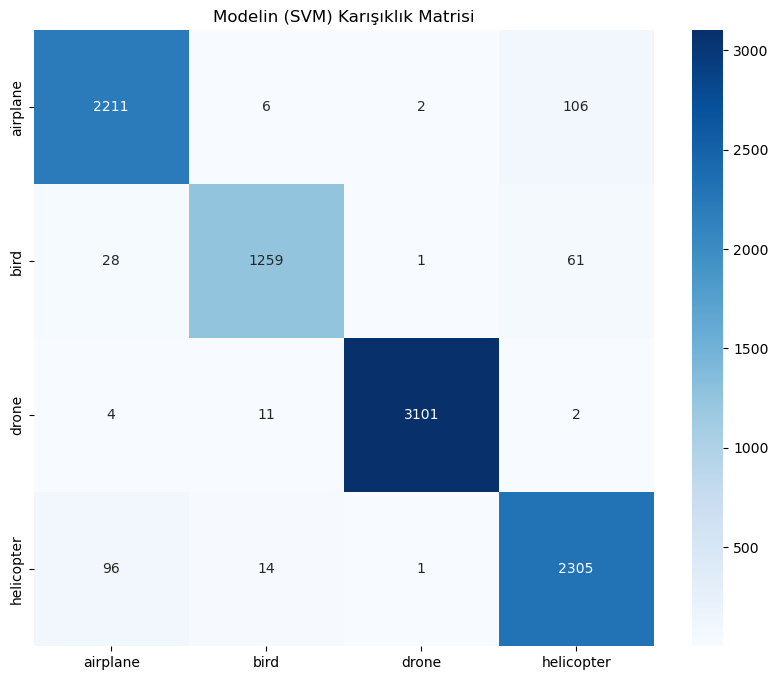


--- Model (MLP) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---

--- MODEL (MLP) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      2325
        bird       0.94      0.91      0.93      1349
       drone       1.00      0.99      0.99      3118
  helicopter       0.90      0.91      0.91      2416

    accuracy                           0.94      9208
   macro avg       0.94      0.93      0.93      9208
weighted avg       0.94      0.94      0.94      9208



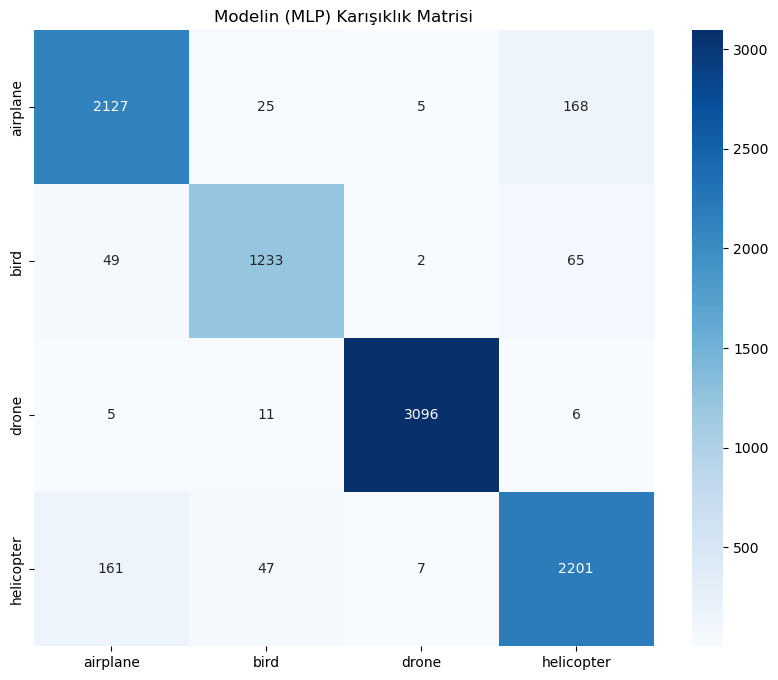


--- Model (XGBoost) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---

--- MODEL (XGBoost) DEĞERLENDİRME RAPORU ---
              precision    recall  f1-score   support

    airplane       0.85      0.87      0.86      2325
        bird       0.97      0.81      0.88      1349
       drone       1.00      0.99      0.99      3118
  helicopter       0.82      0.89      0.85      2416

    accuracy                           0.91      9208
   macro avg       0.91      0.89      0.90      9208
weighted avg       0.91      0.91      0.91      9208



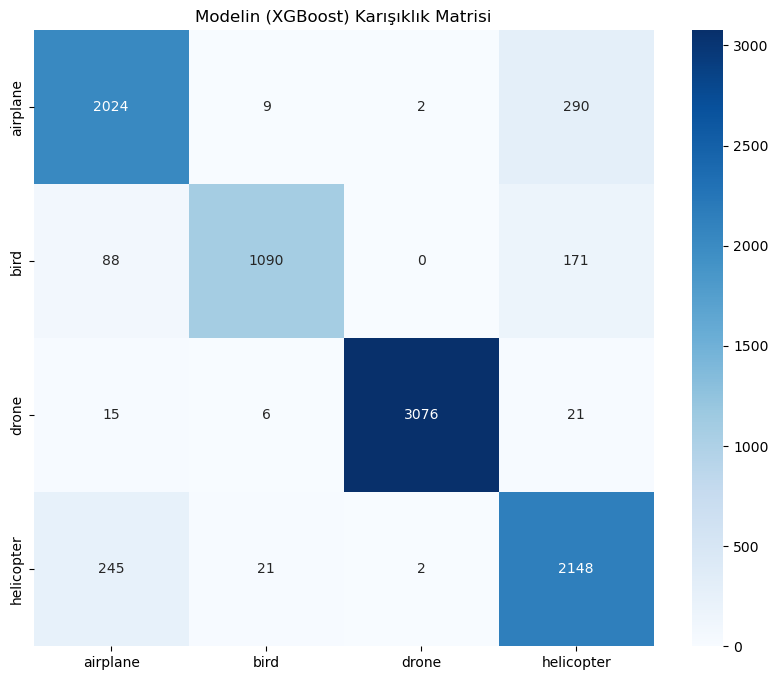

Tüm modeller ve yardımcılar 'all_trained_models.pkl' dosyasına kaydedildi.

[Aşama 2/3] Görüntü piramidi ve kaydırmalı pencere ile nesne tespiti başlıyor...
Piramit Katmanı 1, Ölçek: 1.00, Boyut: (1024, 1024)


Katman 1 taranıyor: 361it [00:59,  6.06it/s]


Piramit Katmanı 2, Ölçek: 1.50, Boyut: (682, 682)


Katman 2 taranıyor: 144it [00:23,  6.14it/s]


Piramit Katmanı 3, Ölçek: 2.26, Boyut: (454, 454)


Katman 3 taranıyor: 49it [00:07,  6.19it/s]


Piramit Katmanı 4, Ölçek: 3.39, Boyut: (302, 302)


Katman 4 taranıyor: 16it [00:02,  6.10it/s]


Piramit Katmanı 5, Ölçek: 5.09, Boyut: (201, 201)


Katman 5 taranıyor: 4it [00:00,  6.22it/s]


Piramit Katmanı 6, Ölçek: 7.64, Boyut: (134, 134)


Katman 6 taranıyor: 1it [00:00,  5.55it/s]


Toplam 1259 adet potansiyel nesne tespit edildi.

[Aşama 3/3] Sonuçlar filtreleniyor ve görselleştiriliyor...
Filtreleme sonrası 135 adet nesne kaldı.


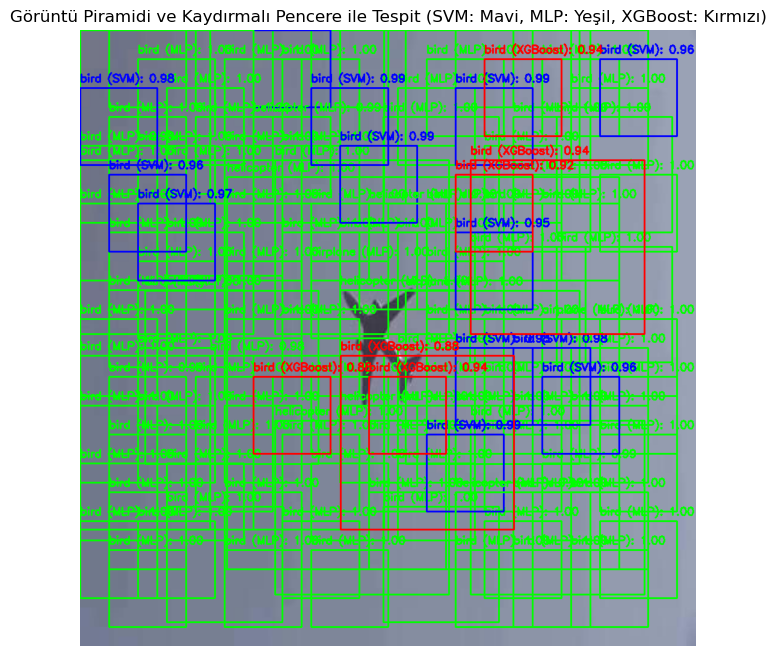

In [3]:
# Gerekli kütüphaneleri projemize dahil ediyoruz
import joblib
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.feature import graycomatrix, graycoprops # YENİ: GLCM için kütüphaneler (Doğru isimler: graycomatrix, graycoprops)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

# =================================================================================
# --- Proje Ayarları ---
# =================================================================================
# Öznitelik çıkarma script'i ile tutarlı olmalı!
HOG_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_4class.pkl' # DEĞİŞTİRİLDİ: GLCM eklendi
TEST_IMAGE_PATH = "test_goruntusu.jpg"
ALL_MODELS_FILE = 'all_trained_models.pkl'

# =================================================================================
# --- Yardımcı Fonksiyonlar Bölümü ---
# =================================================================================
BINS = 8
LBP_POINTS = 24
LBP_RADIUS = 8

# YENİ: GLCM Ayarları
GLCM_DISTANCES = [1, 2] # Komşuluk mesafeleri
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4] # Açılar (0, 45, 90, 135 derece)
GLCM_PROPERTIES = ['energy', 'contrast', 'homogeneity', 'correlation'] # Çıkarılacak GLCM özellikleri
GLCM_LEVELS = 32 # GLCM için kullanılacak gri seviye sayısı

def extract_color_histogram(image, bins=(BINS, BINS, BINS)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, LBP_POINTS + 3),
                                 range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp_hist

# YENİ FONKSİYON: GLCM özniteliklerini çıkarma
def extract_glcm_features(gray_image):
    # GLCM hesaplayabilmek için görüntüyü uygun formata dönüştürüyoruz (uint8 ve level sayısı kadar sıkıştırma)
    # GLCM_LEVELS 256'dan düşükse, piksel değerlerini o aralığa sıkıştırırız.
    # Bu, GLCM matrisinin boyutunu küçültür ve hesaplamayı hızlandırır.
    # Not: Burada BINS yerine GLCM_LEVELS kullanmak daha tutarlı olur.
    # Ancak, eğer BINS (8) değeri GLCM için yeterliyse, onu da kullanabilirsiniz.
    # Ben, GLCM için ayrı bir GLCM_LEVELS (32) tanımladığımızı varsayarak güncelledim.
    img_for_glcm = (gray_image / 255.0 * (GLCM_LEVELS - 1)).astype(np.uint8) 
    
    # Görüntü boyutunu GLCM_DISTANCES ile karşılaştırarak hata oluşmasını engelle
    if img_for_glcm.shape[0] < max(GLCM_DISTANCES) + 1 or img_for_glcm.shape[1] < max(GLCM_DISTANCES) + 1:
        # Eğer pencere çok küçükse, sıfırlardan oluşan bir öznitelik vektörü döndür
        num_glcm_features = len(GLCM_PROPERTIES) * len(GLCM_ANGLES) * len(GLCM_DISTANCES) # GLCM_DISTANCES'ı da çarpıma ekledim
        return np.zeros(num_glcm_features)

    # DÜZELTİLDİ: 'greycomatrix' yerine 'graycomatrix' kullanıldı
    glcm = graycomatrix(img_for_glcm, GLCM_DISTANCES, GLCM_ANGLES, 
                        levels=GLCM_LEVELS, symmetric=True, normed=True) # levels=BINS yerine levels=GLCM_LEVELS kullandım
    
    glcm_features = []
    for prop in GLCM_PROPERTIES:
        # DÜZELTİLDİ: 'greycoprops' yerine 'graycoprops' kullanıldı
        glcm_features.extend(graycoprops(glcm, prop).flatten())
        
    return np.array(glcm_features)


def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, minSize=(128, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] * (w / float(image.shape[1])))))
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image

# =================================================================================
# FAZ A: MODEL SEÇİMİ VE EĞİTİMİ
# =================================================================================

if not os.path.exists(ALL_MODELS_FILE): 
    print(f"\n[Aşama 1/3] Kaydedilmiş modeller bulunamadı. Optimizasyon ve eğitim başlıyor...")
    
    # --- 1. Veri Yükleme ve Hazırlama ---
    # Not: HOG_FEATURES_FILE dosyasını yeniden oluşturmanız gerekecek,
    # çünkü artık GLCM özelliklerini de içerecek.
    # Eğer bu dosyayı elinizde tutan bir scriptiniz varsa, onu da güncellemelisiniz.
    # Şimdilik, bu script içinde bu dosyanın güncellendiğini varsayıyoruz.
    print(f"'{HOG_FEATURES_FILE}' dosyasındaki öznitelikler yükleniyor...")
    data = joblib.load(HOG_FEATURES_FILE)
    X, y_text = data['features'], data['labels']
    
    le = LabelEncoder()
    y = le.fit_transform(y_text)
    class_names = le.classes_
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"\nPCA sonrası yeni öznitelik boyutu: {pca.n_components_}")

    # --- 2. Hızlı Hiper-parametre Optimizasyonu ---
    subset_ratio = 0.20 
    num_subset = int(len(X_train_pca) * subset_ratio)
    X_train_subset = X_train_pca[:num_subset]
    y_train_subset = y_train[:num_subset]
    print(f"Hiper-parametre optimizasyonu için {num_subset} adet alt örneklem kullanılacak.")
    
    models_to_test = {
        'SVM': (SVC(probability=True, random_state=42), {'C': [10, 50], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}),
        'MLP': (MLPClassifier(max_iter=500, random_state=42), {'hidden_layer_sizes': [(100,)], 'alpha': [0.001, 0.01]}),
        'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]})
    }
    best_estimators = {}
    for name, (model, params) in models_to_test.items():
        print(f"\n>>> {name} için hızlı optimizasyon başlıyor...")
        grid_search = GridSearchCV(model, params, cv=2, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_subset, y_train_subset)
        best_estimators[name] = grid_search.best_estimator_
        print(f"En iyi {name} parametreleri: {grid_search.best_params_}")
        print(f"En iyi {name} skoru (alt örneklemde): {grid_search.best_score_:.4f}")

    # --- 3. Tüm Modellerin Final Eğitimi ve Değerlendirilmesi ---
    trained_models = {}
    for name, best_model in best_estimators.items():
        print(f"\n--- Model ({name}) TÜM Eğitim Verisiyle Son Kez Eğitiliyor ---")
        best_model.fit(X_train_pca, y_train)
        trained_models[name] = best_model
        
        print(f"\n--- MODEL ({name}) DEĞERLENDİRME RAPORU ---")
        y_pred = best_model.predict(X_test_pca)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Modelin ({name}) Karışıklık Matrisi')
        plt.show()

    joblib.dump({
        'models': trained_models, 'scaler': scaler, 'pca': pca, 
        'le': le, 'class_names': class_names
    }, ALL_MODELS_FILE)
    print(f"Tüm modeller ve yardımcılar '{ALL_MODELS_FILE}' dosyasına kaydedildi.")

else:
    print(f"\n[Aşama 1/3] Kaydedilmiş '{ALL_MODELS_FILE}' dosyası bulundu. Modeller doğrudan yükleniyor.")

# --- Modelleri Yükleme ---
if 'trained_models' not in locals():
    saved_data = joblib.load(ALL_MODELS_FILE)
    trained_models, scaler, pca, le, class_names = saved_data['models'], saved_data['scaler'], saved_data['pca'], saved_data['le'], saved_data['class_names']

# =================================================================================
# FAZ B ve FAZ C (Bu bölümler önceki haliyle mükemmel çalışıyor, değişiklik yok)
# =================================================================================
print("\n[Aşama 2/3] Görüntü piramidi ve kaydırmalı pencere ile nesne tespiti başlıyor...")

(winW, winH) = (128, 128) 
step_size = 48

image = cv2.imread(TEST_IMAGE_PATH)
if image is None:
    print(f"HATA: Test görüntüsü '{TEST_IMAGE_PATH}' yüklenemedi.")
    exit()
clone = image.copy()
detections = []

PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)
ORIENTATIONS = 9

for i, resized in enumerate(pyramid(image, scale=1.5)):
    scale_factor = image.shape[1] / float(resized.shape[1])
    print(f"Piramit Katmanı {i+1}, Ölçek: {scale_factor:.2f}, Boyut: {resized.shape[:2]}")
    
    for (x, y, window) in tqdm(sliding_window(resized, step_size=step_size, window_size=(winW, winH)), desc=f"Katman {i+1} taranıyor"):
        if window.shape[0] != winH or window.shape[1] != winW: continue
        
        color_window = window
        gray_window = cv2.cvtColor(color_window, cv2.COLOR_BGR2GRAY)
        
        hog_features = hog(gray_window, orientations=ORIENTATIONS,
                           pixels_per_cell=PIXELS_PER_CELL,
                           cells_per_block=CELLS_PER_BLOCK,
                           block_norm='L2-Hys')

        color_features = extract_color_histogram(color_window)
        lbp_features = extract_lbp_features(gray_window)
        glcm_features = extract_glcm_features(gray_window) # YENİ: GLCM özniteliklerini çıkar
        
        # DEĞİŞTİRİLDİ: GLCM öznitelikleri de birleştirildi
        combined_features = np.concatenate([hog_features, color_features, lbp_features, glcm_features]) 
        
        features_scaled = scaler.transform([combined_features])
        features_pca = pca.transform(features_scaled)

        for model_name, model in trained_models.items():
            if model_name == 'XGBoost':
                confidence_threshold = 0.75
            elif model_name == 'MLP':
                confidence_threshold = 0.98
            else: # SVM
                confidence_threshold = 0.95 

            pred_proba = model.predict_proba(features_pca)[0]
            predicted_class_index = np.argmax(pred_proba)
            max_proba = pred_proba[predicted_class_index]
            
            if max_proba > confidence_threshold: 
                class_label = le.inverse_transform([predicted_class_index])[0]
                if class_label in ['bird', 'drone', 'airplane', 'helicopter']: # Sadece ilgi alanınızdaki sınıfları al
                    startX, startY = int(x * scale_factor), int(y * scale_factor)
                    endX, endY = int((x + winW) * scale_factor), int((y + winH) * scale_factor)
                    box = (startX, startY, endX, endY)
                    detections.append((box, max_proba, class_label, model_name)) 

print(f"Toplam {len(detections)} adet potansiyel nesne tespit edildi.")

print("\n[Aşama 3/3] Sonuçlar filtreleniyor ve görselleştiriliyor...")

final_detections = []
detections.sort(key=lambda d: d[1], reverse=True) 
while len(detections) > 0:
    best_detection = detections.pop(0)
    final_detections.append(best_detection)
    (box1, _, _, _) = best_detection
    remaining_detections = []
    for other_detection in detections:
        (box2, _, _, _) = other_detection
        (x1_a, y1_a, x2_a, y2_a) = box1
        (x1_b, y1_b, x2_b, y2_b) = box2
        xA, yA = max(x1_a, x1_b), max(y1_a, y1_b)
        xB, yB = min(x2_a, x2_b), min(y2_a, y2_b)
        interArea = max(0, xB - xA) * max(0, yB - yA)
        if interArea == 0:
            remaining_detections.append(other_detection)
            continue
        boxAArea = (x2_a - x1_a) * (y2_a - y1_a)
        boxBArea = (x2_b - x1_b) * (y2_b - y1_b)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        if iou < 0.3: 
            remaining_detections.append(other_detection)
    detections = remaining_detections

print(f"Filtreleme sonrası {len(final_detections)} adet nesne kaldı.")

model_colors = {'SVM': (255, 0, 0), 'MLP': (0, 255, 0), 'XGBoost': (0, 0, 255)}

for (box, proba, label, model_name) in final_detections:
    (startX, startY, endX, endY) = box
    color = model_colors.get(model_name, (255, 255, 255)) 
    cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)
    label_text = f"{label} ({model_name}): {proba:.2f}"
    cv2.putText(clone, label_text, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.title("Görüntü Piramidi ve Kaydırmalı Pencere ile Tespit (SVM: Mavi, MLP: Yeşil, XGBoost: Kırmızı)")
plt.axis('off')
plt.show()